<a href="https://colab.research.google.com/github/lingliao/Machine-learning-model/blob/main/QE_TabNet_XGB_RF_CNNs_2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabnet

In [ ]:
!pip install pytorch_tabnet
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=fe93585c549a05b9c4587bc241decf4b75af366045d7548ab0c46c7462e37431
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)
import scipy
import os
import wget
from pathlib import Path
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

# Download census-income dataset

In [392]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [393]:

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


**load the data and split**

In [394]:
train = pd.read_csv(out, header = None)
# Set the first row as the header
train.columns = train.iloc[0]

# Drop the first row, which is now the header
# train = train.iloc[1:]

In [395]:
# Select all rows where the last column contains ">"
selected_rows = train[train.iloc[:, -1].str.contains("<")]
selected_rows = selected_rows[selected_rows.iloc[:, -2].str.contains("United-States")]
random_sample = selected_rows.sample(n=7171, random_state=42)
more_rows = train[train.iloc[:, -1].str.contains(">")]
more_rows = more_rows[more_rows.iloc[:, -2].str.contains("United-States")]
combined_df = pd.concat([random_sample, more_rows], axis=0)
combined_df.to_csv('combined_data.txt', sep=',', index=False)

In [396]:
train = combined_df

In [397]:
# Get the last column (final column) and its name
last_column = train.iloc[:, -1]
last_column_name = train.columns[-1]

# Get unique values and their counts in the last column
unique_values = last_column.value_counts()

# Print unique values and their counts
for value, count in unique_values.items():
    print(f'{last_column_name}: {value}, Count: {count}')

 <=50K:  <=50K, Count: 7171
 <=50K:  >50K, Count: 7171


In [398]:
train = train.reset_index(drop=True)

In [399]:
train.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,35,Private,144937,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,42,United-States,<=50K
1,20,Private,131230,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,1590,40,United-States,<=50K
2,20,Private,282604,Some-college,10,Never-married,Handlers-cleaners,Other-relative,White,Male,0,0,20,United-States,<=50K
3,40,Private,143046,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,45,United-States,<=50K
4,48,Private,207120,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [400]:
# train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

**Simple preprocessing**

Label encode categorical features and fill empty cells.

In [401]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 71
 State-gov 9
 Bachelors 16
13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
2174 107
0 76
40 90
 United-States 1
 <=50K 2
Set 3


In [402]:
train.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,18,4,144937,11,8,2,3,0,4,1,0,0,41,0,0,1
1,3,4,131230,11,8,4,7,3,4,1,0,16,39,0,0,1
2,3,4,282604,15,9,4,6,2,4,1,0,0,19,0,0,1
3,23,4,143046,9,12,4,10,1,4,0,0,0,44,0,0,1
4,31,4,207120,15,9,2,10,0,4,1,0,0,39,0,0,1


In [ ]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

**Define categorical features for categorical embeddings**

In [403]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


**Grouped features**

You can now specify groups of feature which will share a common attention.

This may be very usefull for features comming from a same preprocessing technique like PCA for example.
This may also be useless if we do it randomly

In [404]:
len(features)

14

In [405]:
grouped_features = [[0, 1, 2], [8, 9, 10]]

**Network parameters**

In [406]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                 "grouped_features" : grouped_features
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


**Training**

In [407]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [408]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [409]:
# # Find unique labels and their counts
# unique_labels, counts = np.unique(y_test, return_counts=True)

# # Create a DataFrame to display the results
# label_counts_df = pd.DataFrame({'Label': unique_labels, 'Count': counts})

# # Print the DataFrame
# print(label_counts_df)

In [410]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [411]:
# This illustrates the behaviour of the model's fit method using Compressed Sparse Row matrices
sparse_X_train = scipy.sparse.csr_matrix(X_train)  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(X_valid)  # Create a CSR matrix from X_valid

# Fitting the model
clf.fit(
    X_train=sparse_X_train, y_train=y_train,
    eval_set=[(sparse_X_train, y_train), (sparse_X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug, #aug, None
)

epoch 0  | loss: 0.67249 | train_auc: 0.76631 | valid_auc: 0.77001 |  0:00:02s
epoch 1  | loss: 0.53053 | train_auc: 0.80172 | valid_auc: 0.79223 |  0:00:06s
epoch 2  | loss: 0.49628 | train_auc: 0.83011 | valid_auc: 0.81507 |  0:00:15s
epoch 3  | loss: 0.47997 | train_auc: 0.84359 | valid_auc: 0.83525 |  0:00:20s
epoch 4  | loss: 0.47192 | train_auc: 0.85659 | valid_auc: 0.84704 |  0:00:23s
epoch 5  | loss: 0.46464 | train_auc: 0.86443 | valid_auc: 0.85187 |  0:00:28s
epoch 6  | loss: 0.45684 | train_auc: 0.87229 | valid_auc: 0.8521  |  0:00:35s
epoch 7  | loss: 0.44497 | train_auc: 0.87875 | valid_auc: 0.85887 |  0:00:43s
epoch 8  | loss: 0.44215 | train_auc: 0.87812 | valid_auc: 0.86028 |  0:00:46s
epoch 9  | loss: 0.43109 | train_auc: 0.88872 | valid_auc: 0.87032 |  0:00:49s
epoch 10 | loss: 0.43965 | train_auc: 0.89032 | valid_auc: 0.87192 |  0:00:51s
epoch 11 | loss: 0.42825 | train_auc: 0.89616 | valid_auc: 0.87467 |  0:00:55s
epoch 12 | loss: 0.42205 | train_auc: 0.9009  | vali

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [412]:
# This illustrates the warm_start=False behaviour
save_history = []

# Fitting the model without starting from a warm start nor computing the feature importance
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
        compute_importance=False
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

save_history = []  # Resetting the list to show that it also works when computing feature importance

# Fitting the model without starting from a warm start but with the computing of the feature importance activated
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
        compute_importance=True # True by default so not needed
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.67249 | train_auc: 0.76631 | valid_auc: 0.77001 |  0:00:00s
epoch 1  | loss: 0.53053 | train_auc: 0.80172 | valid_auc: 0.79223 |  0:00:01s
epoch 2  | loss: 0.49628 | train_auc: 0.83011 | valid_auc: 0.81507 |  0:00:02s
epoch 3  | loss: 0.47997 | train_auc: 0.84359 | valid_auc: 0.83525 |  0:00:03s
epoch 4  | loss: 0.47192 | train_auc: 0.85659 | valid_auc: 0.84704 |  0:00:04s
epoch 5  | loss: 0.46464 | train_auc: 0.86443 | valid_auc: 0.85187 |  0:00:05s
epoch 6  | loss: 0.45684 | train_auc: 0.87229 | valid_auc: 0.8521  |  0:00:05s
epoch 7  | loss: 0.44497 | train_auc: 0.87875 | valid_auc: 0.85887 |  0:00:06s
epoch 8  | loss: 0.44215 | train_auc: 0.87812 | valid_auc: 0.86028 |  0:00:07s
epoch 9  | loss: 0.43109 | train_auc: 0.88872 | valid_auc: 0.87032 |  0:00:07s
epoch 10 | loss: 0.43965 | train_auc: 0.89032 | valid_auc: 0.87192 |  0:00:08s
epoch 11 | loss: 0.42825 | train_auc: 0.89616 | valid_auc: 0.87467 |  0:00:09s
epoch 12 | loss: 0.42205 | train_auc: 0.9009  | vali

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.67249 | train_auc: 0.76631 | valid_auc: 0.77001 |  0:00:00s
epoch 1  | loss: 0.53053 | train_auc: 0.80172 | valid_auc: 0.79223 |  0:00:01s
epoch 2  | loss: 0.49628 | train_auc: 0.83011 | valid_auc: 0.81507 |  0:00:02s
epoch 3  | loss: 0.47997 | train_auc: 0.84359 | valid_auc: 0.83525 |  0:00:02s
epoch 4  | loss: 0.47192 | train_auc: 0.85659 | valid_auc: 0.84704 |  0:00:03s
epoch 5  | loss: 0.46464 | train_auc: 0.86443 | valid_auc: 0.85187 |  0:00:04s
epoch 6  | loss: 0.45684 | train_auc: 0.87229 | valid_auc: 0.8521  |  0:00:04s
epoch 7  | loss: 0.44497 | train_auc: 0.87875 | valid_auc: 0.85887 |  0:00:05s
epoch 8  | loss: 0.44215 | train_auc: 0.87812 | valid_auc: 0.86028 |  0:00:05s
epoch 9  | loss: 0.43109 | train_auc: 0.88872 | valid_auc: 0.87032 |  0:00:07s
epoch 10 | loss: 0.43965 | train_auc: 0.89032 | valid_auc: 0.87192 |  0:00:08s
epoch 11 | loss: 0.42825 | train_auc: 0.89616 | valid_auc: 0.87467 |  0:00:09s
epoch 12 | loss: 0.42205 | train_auc: 0.9009  | vali

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.67249 | train_auc: 0.76631 | valid_auc: 0.77001 |  0:00:00s
epoch 1  | loss: 0.53053 | train_auc: 0.80172 | valid_auc: 0.79223 |  0:00:01s
epoch 2  | loss: 0.49628 | train_auc: 0.83011 | valid_auc: 0.81507 |  0:00:02s
epoch 3  | loss: 0.47997 | train_auc: 0.84359 | valid_auc: 0.83525 |  0:00:02s
epoch 4  | loss: 0.47192 | train_auc: 0.85659 | valid_auc: 0.84704 |  0:00:03s
epoch 5  | loss: 0.46464 | train_auc: 0.86443 | valid_auc: 0.85187 |  0:00:04s
epoch 6  | loss: 0.45684 | train_auc: 0.87229 | valid_auc: 0.8521  |  0:00:05s
epoch 7  | loss: 0.44497 | train_auc: 0.87875 | valid_auc: 0.85887 |  0:00:06s
epoch 8  | loss: 0.44215 | train_auc: 0.87812 | valid_auc: 0.86028 |  0:00:06s
epoch 9  | loss: 0.43109 | train_auc: 0.88872 | valid_auc: 0.87032 |  0:00:07s
epoch 10 | loss: 0.43965 | train_auc: 0.89032 | valid_auc: 0.87192 |  0:00:08s
epoch 11 | loss: 0.42825 | train_auc: 0.89616 | valid_auc: 0.87467 |  0:00:08s
epoch 12 | loss: 0.42205 | train_auc: 0.9009  | vali

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.67249 | train_auc: 0.76631 | valid_auc: 0.77001 |  0:00:00s
epoch 1  | loss: 0.53053 | train_auc: 0.80172 | valid_auc: 0.79223 |  0:00:01s
epoch 2  | loss: 0.49628 | train_auc: 0.83011 | valid_auc: 0.81507 |  0:00:02s
epoch 3  | loss: 0.47997 | train_auc: 0.84359 | valid_auc: 0.83525 |  0:00:03s
epoch 4  | loss: 0.47192 | train_auc: 0.85659 | valid_auc: 0.84704 |  0:00:04s
epoch 5  | loss: 0.46464 | train_auc: 0.86443 | valid_auc: 0.85187 |  0:00:05s
epoch 6  | loss: 0.45684 | train_auc: 0.87229 | valid_auc: 0.8521  |  0:00:05s
epoch 7  | loss: 0.44497 | train_auc: 0.87875 | valid_auc: 0.85887 |  0:00:06s
epoch 8  | loss: 0.44215 | train_auc: 0.87812 | valid_auc: 0.86028 |  0:00:07s
epoch 9  | loss: 0.43109 | train_auc: 0.88872 | valid_auc: 0.87032 |  0:00:07s
epoch 10 | loss: 0.43965 | train_auc: 0.89032 | valid_auc: 0.87192 |  0:00:08s
epoch 11 | loss: 0.42825 | train_auc: 0.89616 | valid_auc: 0.87467 |  0:00:09s
epoch 12 | loss: 0.42205 | train_auc: 0.9009  | vali

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## Predictions

In [ ]:
# mapping = {'wealthy': 1, 'not_wealthy': 0}
# y_valid_ = np.vectorize(mapping.get)(y_valid)
# y_test_ = np.vectorize(mapping.get)(y_test)


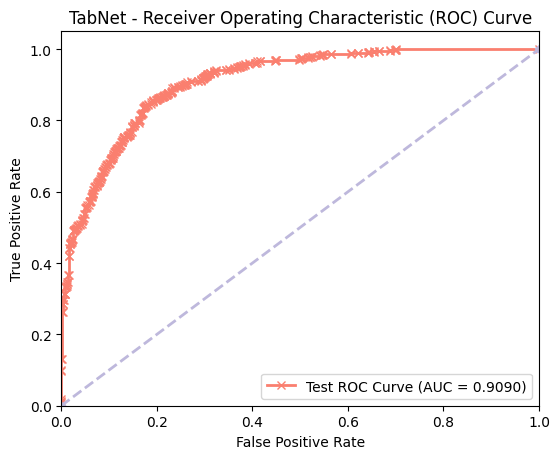

In [413]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming clf.predict_proba(X_test) returns predicted probabilities for the positive class
preds_test = clf.predict_proba(X_test)
fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=preds_test[:, 1])
roc_auc_test = roc_auc_score(y_score=preds_test[:, 1], y_true=y_test)

# # Assuming clf.predict_proba(X_valid) returns predicted probabilities for the positive class
# preds_valid = clf.predict_proba(X_valid)
# fpr_valid, tpr_valid, _ = roc_curve(y_true=y_valid_, y_score=preds_valid[:, 1])
# roc_auc_valid = roc_auc_score(y_score=preds_valid[:, 1], y_true=y_valid)

# Plot ROC curves
plt.figure(figsize=(5.7, 4.7))
plt.plot(fpr_test, tpr_test,marker='x', color = "#FA7F6F", lw=2, label=f'Test ROC Curve (AUC = {roc_auc_test:.4f})')
# plt.plot(fpr_valid, tpr_valid, color='darkblue', lw=2, label=f'Validation ROC Curve (AUC = {roc_auc_valid:.2f})')
plt.plot([0, 1], [0, 1], color='#BEB8DC', lw=2, linestyle='--',marker='p')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TabNet - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the plot as a PDF file with a specific DPI (e.g., 300 DPI)
plt.tight_layout()
plt.savefig("TabNet_roc_auc_plot.pdf", format="pdf", dpi=1000)  # Specify the desired file name, format, and DPI
plt.show()


# Save and load Model

In [414]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [415]:

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [416]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9089527277765133


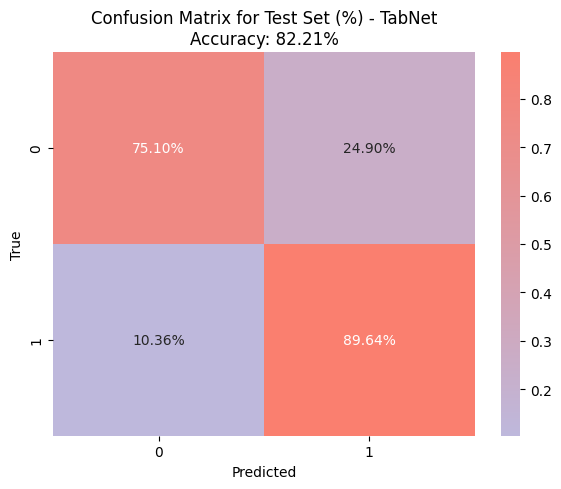

In [417]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Assuming loaded_clf.predict(X_test) returns the predicted labels
# You may need to adjust the threshold for binary classification depending on your problem

# 定义自定义颜色渐变，从绿色到紫色
colors = ['#BEB8DC', '#FA7F6F']  # 绿色到紫色的渐变
cmap_custom = LinearSegmentedColormap.from_list("GreenToPurple", colors)
# For test set
loaded_preds = loaded_clf.predict(X_test)
cm_test = confusion_matrix(y_test, loaded_preds)
# Calculate the confusion matrix in percentage terms
cm_test_percentage = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

# Calculate accuracy for the test set
accuracy = accuracy_score(y_test, loaded_preds)
accuracy_percentage = accuracy * 100

# Plot confusion matrix for validation set with percentages
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test_percentage, annot=True, fmt=".2%", cmap=cmap_custom, xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix for Test Set (%) - TabNet\nAccuracy: {accuracy_percentage:.2f}%")

plt.tight_layout()
plt.savefig("TabNet_confusion_matrix.pdf", format="pdf", dpi=1000)  # Specify the desired file name, format, and DPI
plt.show()

# XGB

In [418]:
# # Assuming you have a DataFrame 'df' with a column 'diagnosis' containing 'M' and 'B' values
# # y_train
# # Create a mapping from 'wealthy' to 1 and 'not_wealthy' to 0
# # mapping = {'wealthy': 1, 'not_wealthy': 0}

# # Use numpy.vectorize to apply the mapping to each element
# y_train_ = np.vectorize(mapping.get)(y_train)
# y_valid_ = np.vectorize(mapping.get)(y_valid)
# y_test_ = np.vectorize(mapping.get)(y_test)

In [420]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Create and train the XGBoost classifier (assuming you've already done this)
clf_xgb = XGBClassifier(max_depth=8, learning_rate=0.1, n_estimators=1000, verbosity=0, silent=None, objective='binary:logistic', booster='gbtree', n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=0.7, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None)
clf_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=40, verbose=10)

# Get the predicted probabilities for the positive class (class 1)
y_pred_prob = clf_xgb.predict_proba(X_valid)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_pred_prob)

# Calculate the ROC AUC score
roc_auc = auc(fpr, tpr)

# # Plot the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()


[0]	validation_0-logloss:0.64738
[10]	validation_0-logloss:0.44641
[20]	validation_0-logloss:0.39398
[30]	validation_0-logloss:0.37502
[40]	validation_0-logloss:0.36505
[50]	validation_0-logloss:0.35867
[60]	validation_0-logloss:0.35595


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[70]	validation_0-logloss:0.35492
[80]	validation_0-logloss:0.35535
[90]	validation_0-logloss:0.35596
[100]	validation_0-logloss:0.35751
[110]	validation_0-logloss:0.36024
[114]	validation_0-logloss:0.36059


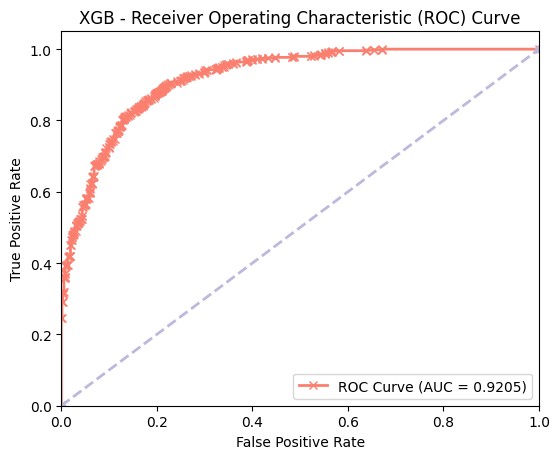

In [421]:
# Get the predicted probabilities for the positive class (class 1)
y_pred_prob = clf_xgb.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Calculate the ROC AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(5.7, 4.7))
plt.plot(fpr, tpr, marker='x', color = "#FA7F6F", lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#BEB8DC', lw=2, linestyle='--', marker = 'p')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the plot as a PDF file with a specific DPI (e.g., 300 DPI)
plt.tight_layout()
plt.savefig("XGB_roc_auc_plot.pdf", format="pdf", dpi=1000)  # Specify the desired file name, format, and DPI
plt.show()

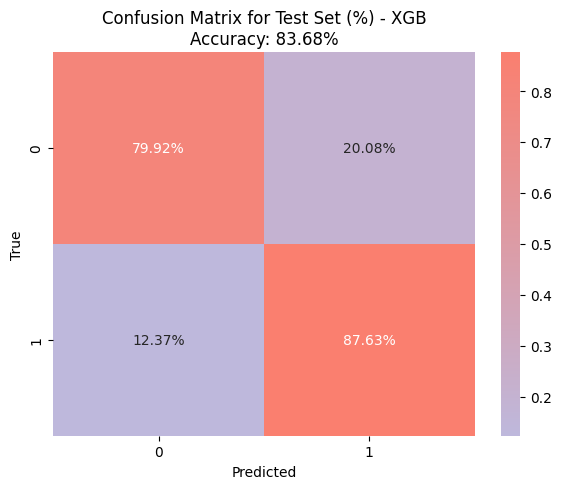

In [422]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# For test set
preds_test = clf_xgb.predict(X_test)
y_test_ = np.vectorize(mapping.get)(y_test)
cm_test = confusion_matrix(y_test, preds_test)

# Calculate the confusion matrix in percentage terms
# cm_valid_percentage = cm_valid.astype('float') / cm_valid.sum(axis=1)[:, np.newaxis]
cm_test_percentage = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

# Calculate accuracy for the test set
accuracy = accuracy_score(y_test, preds_test)
accuracy_percentage = accuracy * 100

# color
colors = ['#BEB8DC', '#FA7F6F']  # green to purple
cmap_custom = LinearSegmentedColormap.from_list("GreenToPurple", colors)

# Plot confusion matrix for test set with percentages
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test_percentage, annot=True, fmt=".2%", cmap=cmap_custom, xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("True")
# plt.title("Confusion Matrix for Test Set (Percentage)")
plt.title(f"Confusion Matrix for Test Set (%) - XGB\nAccuracy: {accuracy_percentage:.2f}%")

plt.tight_layout()
plt.savefig("XGB_confusion_matrix.pdf", format="pdf", dpi=1000)  # Specify the desired file name, format, and DPI
plt.show()

# Random forest

In [423]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss

#model
rf_classifier = RandomForestClassifier(
    n_estimators=10,  # Increase the number of estimators
    max_depth=10,      # Tune max depth
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Train the updated model
rf_classifier.fit(X_train, y_train)

# Initialize lists to store AUC and log loss values for each estimator
auc_values = []
logloss_values = []

# Make predictions on the test set for each estimator
for estimator in rf_classifier.estimators_:
    y_pred = estimator.predict(X_test)

    auc = roc_auc_score(y_test, y_pred)
    auc_values.append(auc)

    y_prob = estimator.predict_proba(X_test)
    logloss = log_loss(y_test, y_prob)
    logloss_values.append(logloss)

# Print AUC and log loss values for each estimator
for i, (auc, logloss) in enumerate(zip(auc_values, logloss_values)):
    print(f'Estimator {i + 1} - AUC: {auc:.2f}, Log Loss: {logloss:.2f}')


Estimator 1 - AUC: 0.78, Log Loss: 1.34
Estimator 2 - AUC: 0.77, Log Loss: 1.06
Estimator 3 - AUC: 0.77, Log Loss: 1.02
Estimator 4 - AUC: 0.80, Log Loss: 0.96
Estimator 5 - AUC: 0.78, Log Loss: 0.89
Estimator 6 - AUC: 0.76, Log Loss: 1.27
Estimator 7 - AUC: 0.79, Log Loss: 1.10
Estimator 8 - AUC: 0.78, Log Loss: 1.00
Estimator 9 - AUC: 0.79, Log Loss: 0.82
Estimator 10 - AUC: 0.81, Log Loss: 1.04


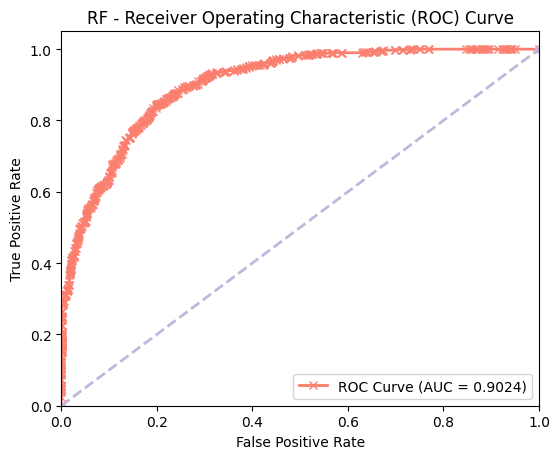

In [424]:
from sklearn.metrics import roc_curve, auc
# Make predictions on the test set using the updated model
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculate the ROC AUC score using a different variable name
roc_auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(5.7, 4.7))
plt.plot(fpr, tpr, marker='x', color = "#FA7F6F", lw=2, label=f'ROC Curve (AUC = {roc_auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='#BEB8DC', lw=2, linestyle='--', marker = 'p')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the plot as a PDF file with a specific DPI (e.g., 300 DPI)
plt.tight_layout()
plt.savefig("RF_roc_auc_plot.pdf", format="pdf", dpi=1000)  # Specify the desired file name, format, and DPI
plt.show()


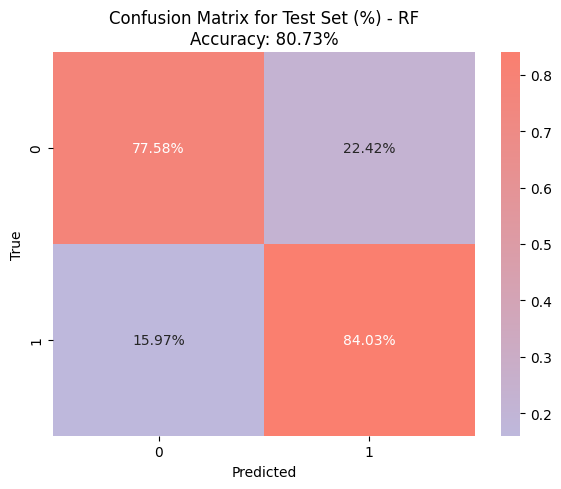

In [425]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Calculate the confusion matrix with percentages (normalized)
confusion_matrix_percentage = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Calculate accuracy for the test set
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# color
colors = ['#BEB8DC', '#FA7F6F']  # green to purple
cmap_custom = LinearSegmentedColormap.from_list("GreenToPurple", colors)
# Plot confusion matrix for test set with percentages
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix_percentage, annot=True, fmt=".2%", cmap=cmap_custom, xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("True")
# plt.title("Confusion Matrix for Test Set (Percentage)")
plt.title(f"Confusion Matrix for Test Set (%) - RF\nAccuracy: {accuracy_percentage:.2f}%")

plt.tight_layout()
plt.savefig("RF_confusion_matrix.pdf", format="pdf", dpi=1000)  # Specify the desired file name, format, and DPI
plt.show()

# CNNs -2.0

In [742]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


In [743]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
data = pd.read_csv("/content/combined_data.txt", names=column_names, na_values=" ?", skipinitialspace=True)

In [744]:
# Remove the first row
data = data.drop(index=0)

# Reset the index if needed
data = data.reset_index(drop=True)

In [745]:
# Preprocess the data
data.dropna(inplace=True)
data = data.drop(columns=["fnlwgt"])  # Dropping non-informative feature
target = data["income"]
data = data.drop(columns=["income"])
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
data = pd.get_dummies(data, columns=categorical_cols)
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Encode the target variable
le = LabelEncoder()
target = le.fit_transform(target)
target = (target == le.transform(['>50K'])[0]).astype(int)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.2, random_state=42)
# Split the data into train, validation, and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)
y_test = torch.LongTensor(y_test)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [746]:
# # Define a simple one-dimensional CNN model
# class CNNModel(nn.Module):
#     def __init__(self, input_dim):
#         super(CNNModel, self).__init__()
#         self.conv1 = nn.Conv1d(1, 16, kernel_size=3)
#         self.fc1 = nn.Linear(16 * (X_train.shape[1] - 2), 128)
#         self.fc2 = nn.Linear(128, 2)  # 2 output classes (<=50K or >50K)

#     def forward(self, x):
#         x = self.conv1(x.unsqueeze(1))  # Add a channel dimension
#         # x = nn.functional.relu(x)
#         x = nn.functional.gelu(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         x = nn.functional.relu(x)
#         # x = nn.functional.gelu(x)
#         x = self.fc2(x)
#         return x

# # Create an instance of the CNN model
# input_dim = X_train.shape[1]
# model = CNNModel(input_dim)

# # Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Create DataLoader for training and testing
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# valid_dataset = TensorDataset(X_valid, y_valid)
# valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

# test_dataset = TensorDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [747]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, input_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3)
        self.fc1 = nn.Linear(16 * (input_dim - 2), 128)
        self.fc2 = nn.Linear(128, 2)  # 2 output classes (<=50K or >50K)
        self.fc3 = nn.Linear(128, 128)  # Additional dense layer with the same size

    def forward(self, x):
        # Initial convolution
        x_conv = self.conv1(x.unsqueeze(1))
        x_conv = F.gelu(x_conv)
        x_conv = x_conv.view(x_conv.size(0), -1)

        # Fully connected layers
        x_fc1 = self.fc1(x_conv)
        x_fc1 = F.relu(x_fc1)

        # Additional dense layer
        x_dense = self.fc3(x_fc1)
        x_dense = F.relu(x_dense)

        # Residual connection
        x_resnet = x_fc1 + x_dense  # Residual connection

        # Final fully connected layer
        x_output = self.fc2(x_resnet)

        return x_output

In [748]:
# Create an instance of the CNN model
input_dim = X_train.shape[1]
model = CNNModel(input_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [749]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calculate and print the validation loss
    model.eval()
    valid_loss = 0.0
    total_valid_samples = 0
    correct_valid_samples = 0
    with torch.no_grad():
        for valid_inputs, valid_labels in valid_loader:
            valid_outputs = model(valid_inputs)
            valid_batch_loss = criterion(valid_outputs, valid_labels)
            valid_loss += valid_batch_loss.item() * valid_inputs.size(0)
            _, valid_predicted = torch.max(valid_outputs, 1)
            total_valid_samples += valid_inputs.size(0)
            correct_valid_samples += (valid_predicted == valid_labels).sum().item()

    average_valid_loss = valid_loss / total_valid_samples
    validation_accuracy = correct_valid_samples / total_valid_samples

    # print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {average_valid_loss:.4f}, Validation Accuracy: {validation_accuracy*100:.2f}%")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {average_valid_loss:.4f}")


Epoch 1/10, Training Loss: 0.3359, Validation Loss: 0.4144
Epoch 2/10, Training Loss: 0.3941, Validation Loss: 0.4184
Epoch 3/10, Training Loss: 0.3135, Validation Loss: 0.4031
Epoch 4/10, Training Loss: 0.3153, Validation Loss: 0.3967
Epoch 5/10, Training Loss: 0.3530, Validation Loss: 0.3990
Epoch 6/10, Training Loss: 0.5038, Validation Loss: 0.3886
Epoch 7/10, Training Loss: 0.4060, Validation Loss: 0.4022
Epoch 8/10, Training Loss: 0.3282, Validation Loss: 0.4033
Epoch 9/10, Training Loss: 0.3792, Validation Loss: 0.3962
Epoch 10/10, Training Loss: 0.2668, Validation Loss: 0.4022


In [750]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 84.53%


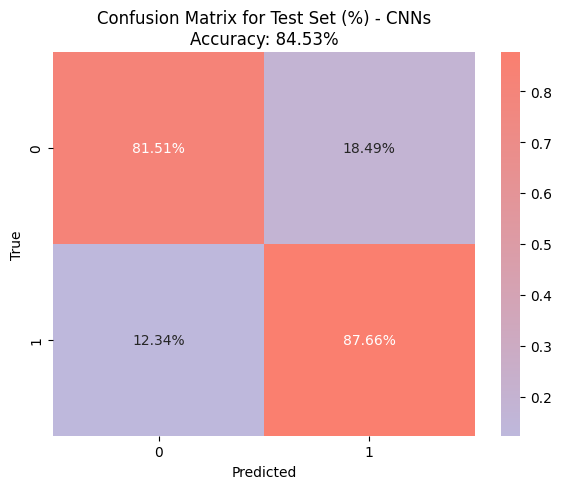

In [751]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import LinearSegmentedColormap

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set and collect true and predicted labels
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate the confusion matrix in percentage terms
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate accuracy for the test set
accuracy = accuracy_score(true_labels, predicted_labels)
accuracy_percentage = accuracy * 100

#color
colors = ['#BEB8DC', '#FA7F6F']  # 绿色到紫色的渐变
cmap_custom = LinearSegmentedColormap.from_list("GreenToPurple", colors)

# Plot the confusion matrix as a heatmap with percentages
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, cmap=cmap_custom, fmt=".2%",xticklabels=["0", "1"], yticklabels=["0", "1"])  # Use ".2%" to format percentages with two decimal places
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix for Test Set (%) - CNNs\nAccuracy: {accuracy_percentage:.2f}%")

plt.tight_layout()
plt.savefig("CNNs_confusion_matrix.pdf", format="pdf", dpi=1000)  # Specify the desired file name, format, and DPI
plt.show()

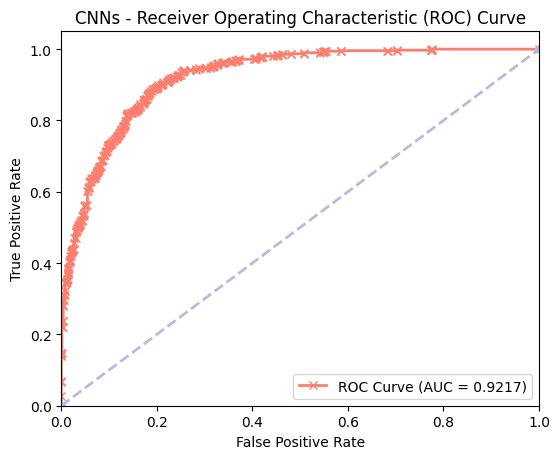

In [752]:
from sklearn.metrics import roc_curve, auc
# Evaluate the model on the test set and get predicted probabilities
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get probabilities for class 1
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(predicted_probs)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


# Plot ROC curve
plt.figure(figsize=(5.7, 4.7))
plt.plot(fpr, tpr,  marker='x', color = "#FA7F6F", lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#BEB8DC', lw=2, linestyle='--',marker = 'p')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNNs - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the plot as a PDF file with a specific DPI (e.g., 300 DPI)
plt.tight_layout()
plt.savefig("CNNs_roc_auc_plot.pdf", format="pdf", dpi=1000)  # Specify the desired file name, format, and DPI
plt.show()

In [753]:
#shuffle the test and run it again
import random

# Shuffle the test set
random.seed(42)  # Seed for reproducibility, change as needed
shuffled_test_set = list(test_loader)
random.shuffle(shuffled_test_set)

# Evaluate the model on the shuffled test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in shuffled_test_set:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy (Shuffled): {accuracy:.2f}%")


Test Accuracy (Shuffled): 84.53%


# The end